[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


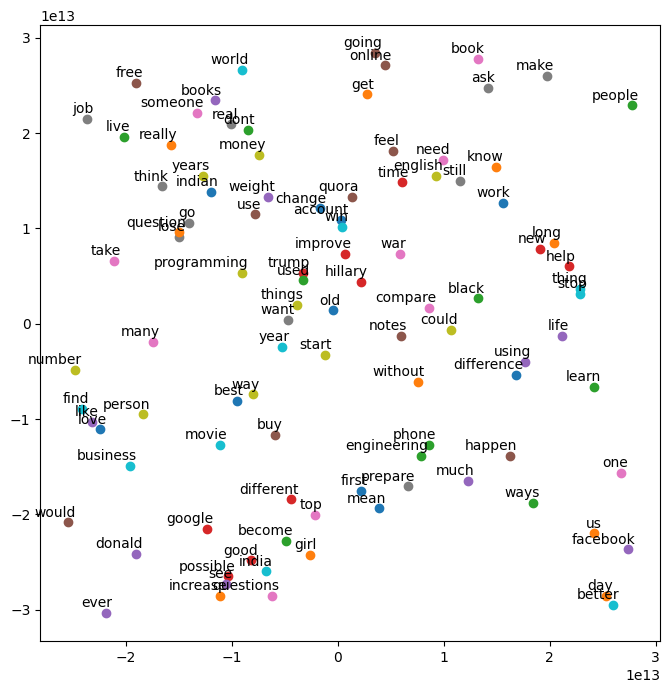

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


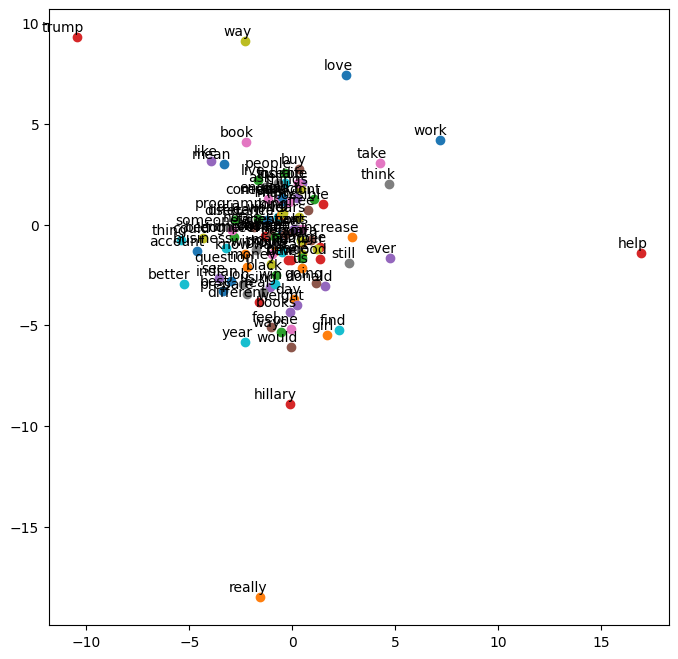

[('expanding', 0.9521538615226746), ('earth', 0.9210258722305298), ('expands', 0.9127558469772339), ('invented', 0.9088733792304993), ('planet', 0.9069170951843262), ('existed', 0.9054722189903259), ('galaxies', 0.895958423614502), ('universes', 0.8916942477226257), ('rotate', 0.8905971646308899), ('cease', 0.8899559378623962)]
[('clinton', 0.9843761920928955), ('hillary', 0.9795217514038086), ('trumpdoes', 0.9574352502822876), ('clintondoes', 0.9477366209030151), ('trumps', 0.9474440813064575), ('clintonis', 0.9410250782966614), ('concede', 0.9363856911659241), ('novemberwhy', 0.9325045347213745), ('hilary', 0.9312832355499268), ('trumphow', 0.9303656220436096)]


In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

# Step 1: Load and Preprocess Data
def load_data(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as archive:
        file_name = archive.namelist()[0]
        with archive.open(file_name) as file:
            text = file.read().decode('utf-8')
    return text

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and word.isalpha()]
    return words

# Step 2: Build Corpus
def build_corpus(text):
    sentences = text.split('\n')
    corpus = [preprocess_text(sentence) for sentence in sentences if sentence]
    return corpus

# Step 3: Train Word2Vec Model
def train_word2vec(corpus):
    model = Word2Vec(sentences=corpus, vector_size=10, window=2, min_count=5, workers=2)
    return model

# Step 4: Implement Custom t-SNE Class
class TSNE_custom:
    def __init__(self, n_components=2, perplexity=5.0, learning_rate=50.0, n_iter=250):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter

    def _compute_pairwise_affinities(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        distances = np.clip(distances, 1e-10, None)
        affinities = np.exp(-distances ** 2 / (2 * self.perplexity ** 2))
        affinities /= np.sum(affinities, axis=1, keepdims=True)
        return affinities

    def _compute_low_dim_affinities(self, Y):
        distances = np.linalg.norm(Y[:, np.newaxis] - Y, axis=2)
        distances = np.clip(distances, 1e-10, None)
        affinities = 1 / (1 + distances ** 2)
        affinities /= np.sum(affinities, axis=1, keepdims=True)
        return affinities

    def fit_transform(self, X, batch_size=200):
        Y = np.random.randn(X.shape[0], self.n_components)
        affinities = self._compute_pairwise_affinities(X)
        for _ in range(self.n_iter):
            for i in range(0, X.shape[0], batch_size):
                batch_Y = Y[i:i+batch_size]
                low_dim_affinities = self._compute_low_dim_affinities(batch_Y)
                gradient = 4 * (affinities[i:i+batch_size] - low_dim_affinities)[:, :, np.newaxis] * (batch_Y[:, np.newaxis] - batch_Y)
                gradient = np.clip(gradient, -1e10, 1e10)
                Y[i:i+batch_size] -= self.learning_rate * np.sum(gradient, axis=1)
        return Y

# Step 5: Visualizing t-SNE Representations
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(8, 8))
    for i, label in enumerate(labels[:100]):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

# Load dataset
text_data = load_data('train.zip')
corpus = build_corpus(text_data)
model = train_word2vec(corpus)
word_vectors = np.array([model.wv[word] for word in model.wv.index_to_key[:100]])
labels = list(model.wv.index_to_key[:100])

# Custom t-SNE
custom_tsne = TSNE_custom(n_components=2, perplexity=5, n_iter=250)
low_dim_embeddings = custom_tsne.fit_transform(word_vectors, batch_size=200)
plot_embeddings(low_dim_embeddings, labels)

# Step 6: Using Sci-kit Learn's t-SNE
sklearn_tsne = TSNE(n_components=2, perplexity=5, n_iter=250, random_state=23)
sklearn_low_dim_embeddings = sklearn_tsne.fit_transform(word_vectors)
plot_embeddings(sklearn_low_dim_embeddings, labels)

# Step 7: Running Inferences
print(model.wv.most_similar('universe'))
print(model.wv.most_similar('trump'))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True